Load relevant packages

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.preprocessing.image
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import os;
import datetime  
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm  

Using TensorFlow backend.


Load and shuffle lymphoma images

x_images.shape = (5547, 50, 50, 3)
x_images.min/mean/std/max = 2.00/185.03/47.25/255.00

y_images.shape = (5547,)
y_images.min/mean/std/max = 0.00/0.50/0.50/1.00
red channel: min/mean/std/max = 4.00/205.79/36.29/255.00
green channel: min/mean/std/max = 2.00/161.87/53.94/255.00
blue channel: min/mean/std/max = 5.00/187.44/38.69/255.00


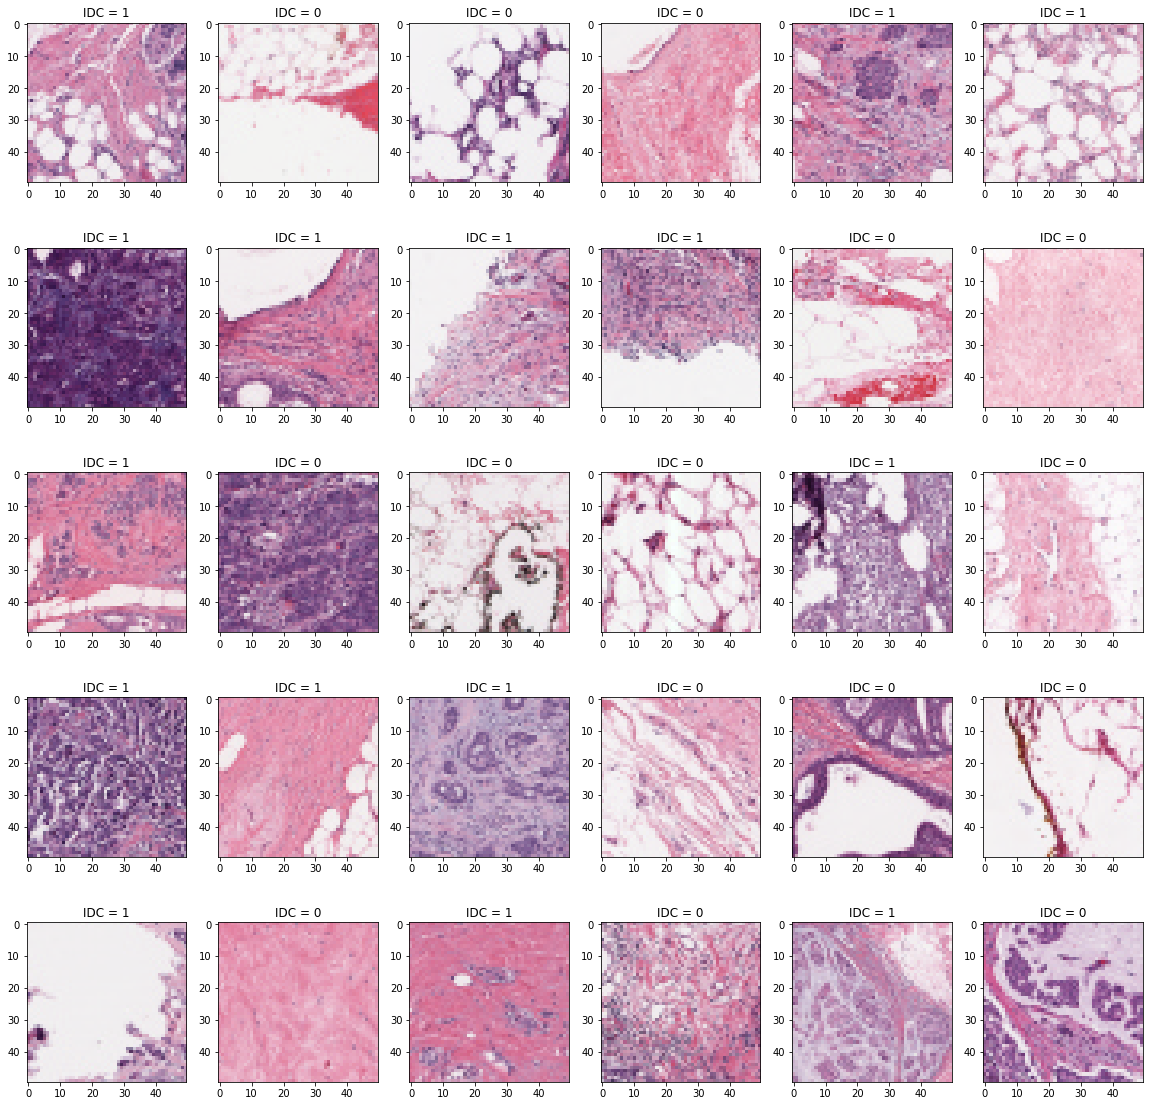

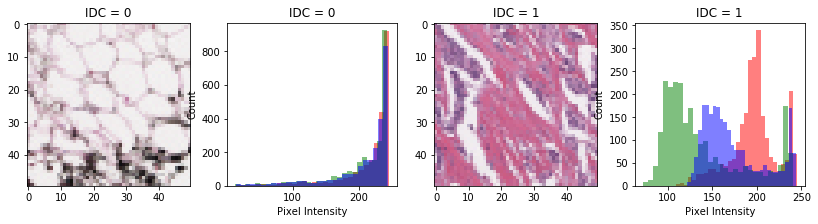

In [2]:
x_images = np.load('C:\\Users\jsvz\OneDrive - Chevron\Documents\Python Scripts\Ben\X.npy')
 
y_images = np.load('C:\\Users\jsvz\OneDrive - Chevron\Documents\Python Scripts\Ben\Y.npy') 

perm_array = np.arange(len(x_images))
np.random.shuffle(perm_array)
x_images = x_images[perm_array]
y_images = y_images[perm_array]

print('x_images.shape =', x_images.shape)
print('x_images.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(x_images.min(),
                        x_images.mean(), x_images.std(), x_images.max()))
print('')
print('y_images.shape =', y_images.shape)
print('y_images.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(y_images.min(),
                        y_images.mean(), y_images.std(), y_images.max()))


imgs_0 = x_images[y_images == 0] # 0 = no cancer
imgs_1 = x_images[y_images == 1] # 1 = cancer

plt.figure(figsize=(20,20))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.title('IDC = %d'%y_images[i])
    plt.imshow(x_images[i])
    
plt.figure(figsize=(14,3))

for i in range(2):
    n_img = np.random.randint(len(x_images))
    plt.subplot(1,4,1+2*i)
    plt.title('IDC = %d'%y_images[n_img])
    plt.imshow(x_images[n_img])
    plt.subplot(1,4,2+2*i)
    plt.title('IDC = %d'%y_images[n_img])
    plt.ylabel('Count')
    plt.xlabel('Pixel Intensity')
    plt.hist(x_images[n_img,:,:,0].flatten(), bins=30, lw = 0,color='r', alpha=0.5);
    plt.hist(x_images[n_img,:,:,1].flatten(), bins=30, lw = 0, color='g', alpha=0.5);
    plt.hist(x_images[n_img,:,:,2].flatten(), bins=30, lw = 0, color='b', alpha=0.5);

print('red channel: min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(x_images[:,:,:,0].min(),
    x_images[:,:,:,0].mean(), x_images[:,:,:,0].std(), x_images[:,:,:,0].max()))
print('green channel: min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(x_images[:,:,:,1].min(),
    x_images[:,:,:,1].mean(), x_images[:,:,:,1].std(), x_images[:,:,:,1].max()))
print('blue channel: min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(x_images[:,:,:,2].min(),
    x_images[:,:,:,2].mean(), x_images[:,:,:,2].std(), x_images[:,:,:,2].max()))

Define some functions

In [8]:
# convert one-hot encodings into labels
def one_hot_to_dense(labels_one_hot):
    return np.argmax(labels_one_hot,1)

# convert class labels from scalars to one-hot vectors e.g. 1 => [0 1], 0 => [1 0]
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

# function to normalize data
def normalize_data(data): 
    # scale features using statistics that are robust to outliers
    #rs = sklearn.preprocessing.RobustScaler()
    #rs.fit(data)
    #data = rs.transform(data)
    #data = (data-data.mean())/(data.std()) # standardisation
    data = data / data.max() # convert from [0:255] to [0.:1.]
    #data = ((data / 255.)-0.5)*2. # convert from [0:255] to [-1.:+1.]
    return data

Train test split

In [9]:
# training and validation data
x_train_valid = normalize_data(x_images)

# use one-hot encoding for labels 0,1
y_train_valid = dense_to_one_hot(y_images, 2).astype(np.uint8)

# dictionaries for saving results
y_valid_pred = {}
y_train_pred = {}
y_test_pred = {}
train_loss, valid_loss = {}, {}
train_acc, valid_acc = {}, {}
cnf_valid_matrix = {}

print('x_train_valid.shape =', x_train_valid.shape)
print('x_train_valid.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(x_train_valid.min(),
                        x_train_valid.mean(), x_train_valid.std(), x_train_valid.max()))
print('')
print('y_train_valid.shape =', y_train_valid.shape)
print('y_train_valid.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(y_train_valid.min(),
                        y_train_valid.mean(), y_train_valid.std(), y_train_valid.max()))

x_train_valid.shape = (5547, 50, 50, 3)
x_train_valid.min/mean/std/max = 0.01/0.73/0.19/1.00

y_train_valid.shape = (5547, 2)
y_train_valid.min/mean/std/max = 0.00/0.50/0.50/1.00


Augment data function

In [10]:
## augment data

# generate new images via rotations, translations, zoom using keras
def generate_images(imgs):
    
    # rotations, translations, zoom
    image_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range = 10, width_shift_range = 0.1 , height_shift_range = 0.1,
        zoom_range = 0.1)

    # get transformed images
    imgs = image_generator.flow(imgs.copy(), np.zeros(len(imgs)),
                                batch_size=len(imgs), shuffle = False).next()    
    return imgs[0]

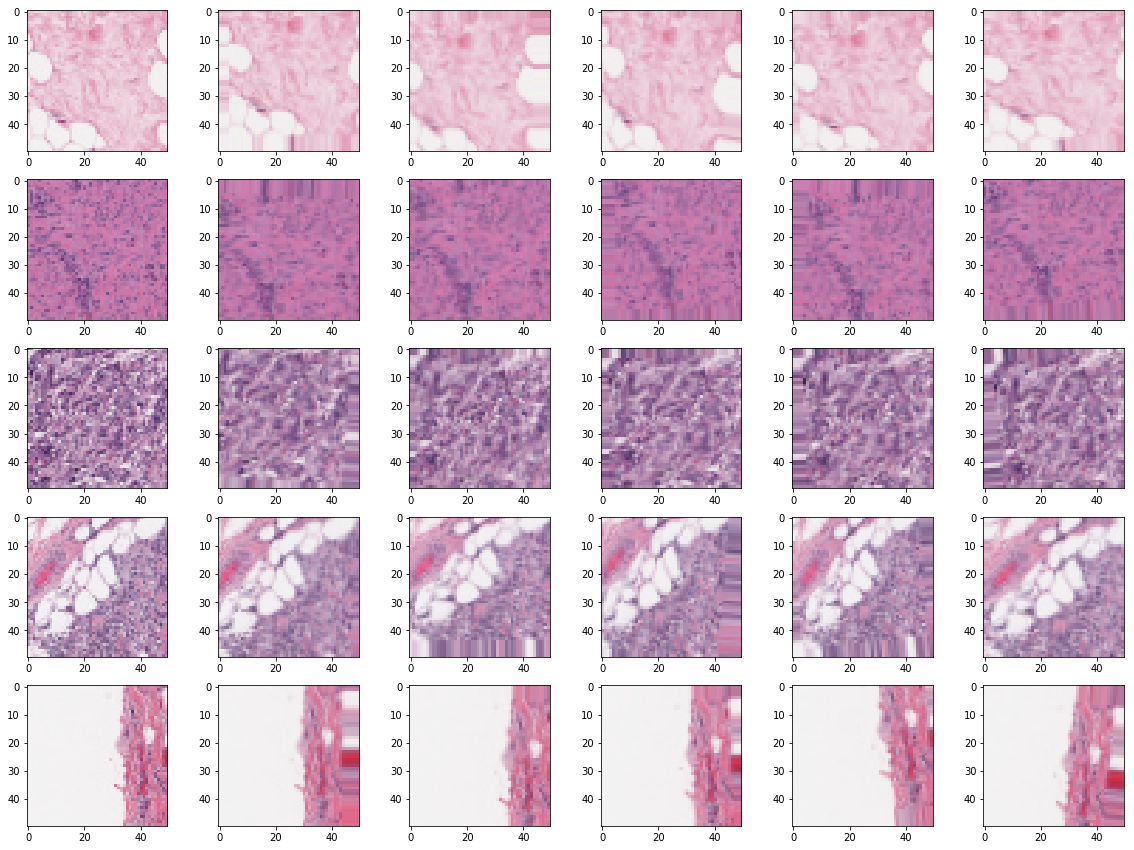

In [11]:
# check image generation
fig,axs = plt.subplots(5,6, figsize=(20,15))
for i in range(5):
    n = np.random.randint(0,x_images.shape[0]-2)
    axs[i,0].imshow(x_images[n])
    axs[i,1].imshow(generate_images(x_images[n:n+1])[0].astype('uint8'))
    axs[i,2].imshow(generate_images(x_images[n:n+1])[0].astype('uint8'))
    axs[i,3].imshow(generate_images(x_images[n:n+1])[0].astype('uint8'))
    axs[i,4].imshow(generate_images(x_images[n:n+1])[0].astype('uint8'))
    axs[i,5].imshow(generate_images(x_images[n:n+1])[0].astype('uint8'))

Try out basic sklearn models

In [12]:
# compute the accuracy of label predictions
def accuracy_from_dense_labels(y_target, y_pred):
    y_target = y_target.reshape(-1,)
    y_pred = y_pred.reshape(-1,)
    return np.mean(y_target == y_pred)

In [40]:
nn_name = ['nn0','nn1','nn2','nn3','nn4','nn5','nn6','nn7','nn8','nn9']

# cross validations
cv_num = 10 # cross validations default = 20 => 5% validation set
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True, random_state=123)

for i,(train_index, valid_index) in enumerate(kfold.split(x_train_valid)):
    
    # start timer
    start = datetime.datetime.now();
    
    # train and validation data of original images
    x_train = x_train_valid[train_index]
    y_train = y_train_valid[train_index]
    x_valid = x_train_valid[valid_index]
    y_valid = y_train_valid[valid_index]
    
    # create neural network graph
    nn_graph = nn_class(nn_name = nn_name[i]) # instance of nn_class
    nn_graph.create_graph() # create graph
    nn_graph.attach_saver() # attach saver tensors
    
    # start tensorflow session
    with tf.Session() as sess:
        
        # attach summaries
        nn_graph.attach_summary(sess) 
        
        # variable initialization of the default graph
        sess.run(tf.global_variables_initializer()) 
    
        # training on original data
        nn_graph.train_graph(sess, x_train, y_train, x_valid, y_valid, n_epoch = 1.)
        
        # training on augmented data
        nn_graph.train_graph(sess, x_train, y_train, x_valid, y_valid, n_epoch = 29.,
                             train_on_augmented_data = True)

        # save tensors and summaries of model
        nn_graph.save_model(sess)
    
    break
    
print('total running time for training: ', datetime.datetime.now() - start)

logreg = sklearn.linear_model.LogisticRegression(verbose=0, solver='lbfgs',
                                                 multi_class = 'multinomial')
decision_tree = sklearn.tree.DecisionTreeClassifier()
extra_trees = sklearn.ensemble.ExtraTreesClassifier(verbose=0, max_depth=4)
gradient_boost = sklearn.ensemble.GradientBoostingClassifier(verbose=0)
random_forest = sklearn.ensemble.RandomForestClassifier(verbose=0, max_depth=4, n_estimators=10)
gaussianNB = sklearn.naive_bayes.GaussianNB()
DummyClassifier = sklearn.dummy.DummyClassifier(strategy= 'stratified', random_state=None, constant=None)


# store models in dictionary
base_models = {'logreg': logreg, 'extra_trees': extra_trees,
               'gradient_boost': gradient_boost, 'random_forest': random_forest, 
               'decision_tree': decision_tree, 'gaussianNB': gaussianNB, 'DummyClassifier': DummyClassifier, 'neuralnetwork': nn_graph}

# choose models for out-of-folds predictions
#take_models = ['logreg','random_forest','extra_trees','gaussianNB']
take_models = ['logreg', 'random_forest', 'extra_trees', 'gaussianNB', 'DummyClassifier' ]

for mn in take_models:
    train_acc[mn] = []
    valid_acc[mn] = []
    cnf_valid_matrix[mn] = []

# start timer
start = datetime.datetime.now();
print(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'),': start training')
       
# cross validations
cv_num = 10 # cross validations default = 20 => 5% validation set
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True) #, random_state=123)

for i,(train_index, valid_index) in enumerate(kfold.split(x_train_valid)):

    # start timer
    start = datetime.datetime.now();

    # train and validation data of original images
    x_train = x_train_valid[train_index].reshape(-1,7500)
    y_train = y_train_valid[train_index]
    x_valid = x_train_valid[valid_index].reshape(-1,7500)
    y_valid = y_train_valid[valid_index]

    for mn in take_models:

        # create cloned model from base models
        model = sklearn.base.clone(base_models[mn])
        model.fit(x_train, one_hot_to_dense(y_train))

        # predictions
        y_train_pred[mn] = model.predict_proba(x_train)
        y_valid_pred[mn] = model.predict_proba(x_valid)
        
        # accuracies
        train_acc[mn].append(accuracy_from_dense_labels(one_hot_to_dense(y_train_pred[mn]),
                                                        one_hot_to_dense(y_train)))
        valid_acc[mn].append(accuracy_from_dense_labels(one_hot_to_dense(y_valid_pred[mn]),
                                                        one_hot_to_dense(y_valid)))
        
        # normalized confusion matrix
        cnf_valid_matrix_tmp = sklearn.metrics.confusion_matrix(
            y_pred = one_hot_to_dense(y_valid_pred[mn]), 
            y_true = one_hot_to_dense(y_valid)).astype(np.float32)
        cnf_valid_matrix_tmp[0,:] = cnf_valid_matrix_tmp[0,:]/cnf_valid_matrix_tmp[0,:].sum()
        cnf_valid_matrix_tmp[1,:] = cnf_valid_matrix_tmp[1,:]/cnf_valid_matrix_tmp[1,:].sum()
        cnf_valid_matrix[mn].append(cnf_valid_matrix_tmp)

        print(i,': '+mn+' train/valid accuracy = %.3f/%.3f'%(train_acc[mn][-1], 
                                                             valid_acc[mn][-1]))

print('running time for training: ', datetime.datetime.now() - start)
print('')
for mn in train_acc.keys():
    print(mn + ' : averaged train/valid accuracy = %.3f/%.3f'%(np.mean(train_acc[mn]),
                                                              np.mean(valid_acc[mn])))


num_weights = 357228
num_biases = 684
12-02-2020 17:25:22 : start training
learnrate = 0.001 , n_epoch = 1.0 , mb_size = 50 , nn_name = nn0
0.01 epoch: train/val loss = 4.2978/4.3127, train/val acc = 0.5027/0.5027
0.10 epoch: train/val loss = 0.7688/0.7775, train/val acc = 0.5027/0.5027
0.19 epoch: train/val loss = 0.6634/0.6625, train/val acc = 0.6523/0.6505
0.28 epoch: train/val loss = 0.6551/0.6372, train/val acc = 0.6000/0.6144
0.37 epoch: train/val loss = 0.6043/0.5769, train/val acc = 0.6793/0.7225
0.46 epoch: train/val loss = 0.5931/0.5732, train/val acc = 0.6919/0.7243
0.55 epoch: train/val loss = 0.5813/0.5569, train/val acc = 0.7063/0.7477
0.64 epoch: train/val loss = 0.5750/0.5313, train/val acc = 0.6901/0.7423
0.73 epoch: train/val loss = 0.5605/0.5348, train/val acc = 0.7171/0.7586
0.82 epoch: train/val loss = 0.5546/0.5194, train/val acc = 0.7315/0.7622
0.91 epoch: train/val loss = 0.6640/0.6418, train/val acc = 0.6577/0.6667
1.00 epoch: train/val loss = 0.6383/0.6272, tr

9.12 epoch: train/val loss = 0.4910/0.4552, train/val acc = 0.7477/0.8126
9.21 epoch: train/val loss = 0.4939/0.4623, train/val acc = 0.7730/0.7982
9.30 epoch: train/val loss = 0.4880/0.4634, train/val acc = 0.7514/0.8018
9.40 epoch: train/val loss = 0.5078/0.4815, train/val acc = 0.7640/0.7874
9.49 epoch: train/val loss = 0.4898/0.4632, train/val acc = 0.7802/0.8054
9.58 epoch: train/val loss = 0.4909/0.4587, train/val acc = 0.7622/0.7964
9.67 epoch: train/val loss = 0.4904/0.4605, train/val acc = 0.7730/0.7982
9.76 epoch: train/val loss = 0.5103/0.4811, train/val acc = 0.7495/0.7784
9.85 epoch: train/val loss = 0.4943/0.4612, train/val acc = 0.7514/0.7910
generate new set of images
9.94 epoch: train/val loss = 0.4800/0.4660, train/val acc = 0.7784/0.7910
10.03 epoch: train/val loss = 0.4562/0.4536, train/val acc = 0.7946/0.8126
10.12 epoch: train/val loss = 0.4981/0.4847, train/val acc = 0.7712/0.7820
10.21 epoch: train/val loss = 0.4553/0.4589, train/val acc = 0.7910/0.7964
10.30 ep

18.59 epoch: train/val loss = 0.4554/0.4506, train/val acc = 0.7658/0.8144
18.68 epoch: train/val loss = 0.4980/0.4906, train/val acc = 0.7514/0.7802
18.77 epoch: train/val loss = 0.4486/0.4474, train/val acc = 0.7802/0.8144
generate new set of images
18.86 epoch: train/val loss = 0.4487/0.4663, train/val acc = 0.7946/0.7982
18.95 epoch: train/val loss = 0.4562/0.4828, train/val acc = 0.7946/0.7838
19.04 epoch: train/val loss = 0.4369/0.4428, train/val acc = 0.8108/0.8180
19.13 epoch: train/val loss = 0.4347/0.4456, train/val acc = 0.8108/0.8198
19.22 epoch: train/val loss = 0.4406/0.4560, train/val acc = 0.8054/0.8090
19.31 epoch: train/val loss = 0.4457/0.4463, train/val acc = 0.7964/0.8162
19.40 epoch: train/val loss = 0.4382/0.4468, train/val acc = 0.8054/0.8216
19.49 epoch: train/val loss = 0.4369/0.4462, train/val acc = 0.8072/0.8180
19.58 epoch: train/val loss = 0.4415/0.4591, train/val acc = 0.8054/0.8036
19.67 epoch: train/val loss = 0.4378/0.4514, train/val acc = 0.8072/0.810

27.96 epoch: train/val loss = 0.4098/0.4396, train/val acc = 0.8234/0.8126
28.05 epoch: train/val loss = 0.4229/0.4462, train/val acc = 0.8180/0.8198
28.15 epoch: train/val loss = 0.4413/0.4581, train/val acc = 0.8090/0.8036
28.24 epoch: train/val loss = 0.4402/0.4573, train/val acc = 0.8108/0.8054
28.33 epoch: train/val loss = 0.4302/0.4505, train/val acc = 0.8162/0.8162
28.42 epoch: train/val loss = 0.4223/0.4459, train/val acc = 0.8144/0.8144
28.51 epoch: train/val loss = 0.4221/0.4459, train/val acc = 0.8126/0.8162
28.60 epoch: train/val loss = 0.4149/0.4423, train/val acc = 0.8198/0.8162
28.69 epoch: train/val loss = 0.4132/0.4412, train/val acc = 0.8216/0.8126
generate new set of images
28.78 epoch: train/val loss = 0.4577/0.4460, train/val acc = 0.7838/0.8180
28.87 epoch: train/val loss = 0.4623/0.4495, train/val acc = 0.7820/0.8162
28.96 epoch: train/val loss = 0.4601/0.4484, train/val acc = 0.7838/0.8126
29.05 epoch: train/val loss = 0.4574/0.4470, train/val acc = 0.7802/0.818

C:\Users\jsvz\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0 : logreg train/valid accuracy = 0.843/0.710
0 : random_forest train/valid accuracy = 0.785/0.755


C:\Users\jsvz\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0 : extra_trees train/valid accuracy = 0.771/0.733
0 : gaussianNB train/valid accuracy = 0.722/0.656
0 : DummyClassifier train/valid accuracy = 0.482/0.494


C:\Users\jsvz\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


1 : logreg train/valid accuracy = 0.858/0.679
1 : random_forest train/valid accuracy = 0.785/0.750


C:\Users\jsvz\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1 : extra_trees train/valid accuracy = 0.772/0.733
1 : gaussianNB train/valid accuracy = 0.715/0.710
1 : DummyClassifier train/valid accuracy = 0.497/0.486


C:\Users\jsvz\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


2 : logreg train/valid accuracy = 0.852/0.674
2 : random_forest train/valid accuracy = 0.784/0.759


C:\Users\jsvz\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


2 : extra_trees train/valid accuracy = 0.772/0.748
2 : gaussianNB train/valid accuracy = 0.716/0.708
2 : DummyClassifier train/valid accuracy = 0.501/0.477


C:\Users\jsvz\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


3 : logreg train/valid accuracy = 0.837/0.703
3 : random_forest train/valid accuracy = 0.782/0.813


C:\Users\jsvz\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


3 : extra_trees train/valid accuracy = 0.768/0.795
3 : gaussianNB train/valid accuracy = 0.710/0.778
3 : DummyClassifier train/valid accuracy = 0.493/0.492


C:\Users\jsvz\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


4 : logreg train/valid accuracy = 0.847/0.694
4 : random_forest train/valid accuracy = 0.781/0.778


C:\Users\jsvz\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


4 : extra_trees train/valid accuracy = 0.768/0.768
4 : gaussianNB train/valid accuracy = 0.713/0.732
4 : DummyClassifier train/valid accuracy = 0.504/0.468


C:\Users\jsvz\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


5 : logreg train/valid accuracy = 0.871/0.714
5 : random_forest train/valid accuracy = 0.785/0.782


C:\Users\jsvz\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


5 : extra_trees train/valid accuracy = 0.773/0.760
5 : gaussianNB train/valid accuracy = 0.715/0.721
5 : DummyClassifier train/valid accuracy = 0.492/0.505


C:\Users\jsvz\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


6 : logreg train/valid accuracy = 0.860/0.665
6 : random_forest train/valid accuracy = 0.785/0.762


C:\Users\jsvz\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


6 : extra_trees train/valid accuracy = 0.768/0.764
6 : gaussianNB train/valid accuracy = 0.713/0.733
6 : DummyClassifier train/valid accuracy = 0.515/0.488


C:\Users\jsvz\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


7 : logreg train/valid accuracy = 0.845/0.695
7 : random_forest train/valid accuracy = 0.786/0.762


C:\Users\jsvz\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


7 : extra_trees train/valid accuracy = 0.776/0.764
7 : gaussianNB train/valid accuracy = 0.717/0.688
7 : DummyClassifier train/valid accuracy = 0.509/0.496


C:\Users\jsvz\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


8 : logreg train/valid accuracy = 0.860/0.668
8 : random_forest train/valid accuracy = 0.789/0.718


C:\Users\jsvz\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


8 : extra_trees train/valid accuracy = 0.775/0.726
8 : gaussianNB train/valid accuracy = 0.717/0.699
8 : DummyClassifier train/valid accuracy = 0.505/0.504


C:\Users\jsvz\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


9 : logreg train/valid accuracy = 0.837/0.686
9 : random_forest train/valid accuracy = 0.789/0.769


C:\Users\jsvz\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


9 : extra_trees train/valid accuracy = 0.771/0.755
9 : gaussianNB train/valid accuracy = 0.715/0.715
9 : DummyClassifier train/valid accuracy = 0.508/0.504
running time for training:  0:00:15.530772

logreg : averaged train/valid accuracy = 0.851/0.689
random_forest : averaged train/valid accuracy = 0.785/0.765
extra_trees : averaged train/valid accuracy = 0.771/0.754
gaussianNB : averaged train/valid accuracy = 0.715/0.714
DummyClassifier : averaged train/valid accuracy = 0.501/0.491


plot

NameError: name 'cnf_valid_matrix' is not defined

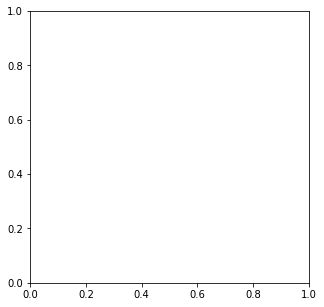

In [70]:
labels_array = ['IDC = 0', 'IDC = 1']
fig, ax = plt.subplots(1,figsize=(5,5))
ax = sns.heatmap(cnf_valid_matrix['neural_network'], ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(labels_array)
ax.set_yticklabels(labels_array)
plt.title('Confusion matrix of validation set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();    

mn = 'logreg'


plot

NameError: name 'cnf_valid_matrix' is not defined

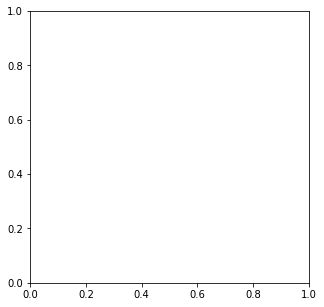

In [71]:
labels_array = ['IDC = 0', 'IDC = 1']
fig, ax = plt.subplots(1,figsize=(5,5))
ax = sns.heatmap(cnf_valid_matrix[mn][0], ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(labels_array)
ax.set_yticklabels(labels_array)
plt.title('Confusion matrix of validation set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

choose model

In [72]:
mn = 'random_forest'

plot

NameError: name 'cnf_valid_matrix' is not defined

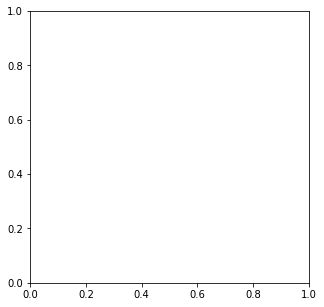

In [73]:
labels_array = ['IDC = 0', 'IDC = 1']
fig, ax = plt.subplots(1,figsize=(5,5))
ax = sns.heatmap(cnf_valid_matrix[mn][0], ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(labels_array)
ax.set_yticklabels(labels_array)
plt.title('Confusion matrix of validation set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

choose model

In [76]:
mn = 'extra_trees'

 plot

NameError: name 'cnf_valid_matrix' is not defined

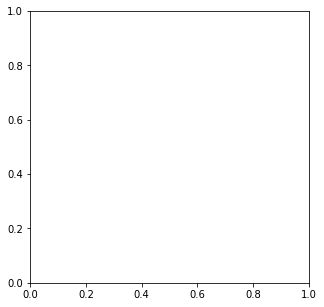

In [78]:
labels_array = ['IDC = 0', 'IDC = 1']
fig, ax = plt.subplots(1,figsize=(5,5))
ax = sns.heatmap(cnf_valid_matrix[mn][0], ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(labels_array)
ax.set_yticklabels(labels_array)
plt.title('Confusion matrix of validation set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

choose model

In [79]:
mn = 'gaussianNB'

 plot

NameError: name 'cnf_valid_matrix' is not defined

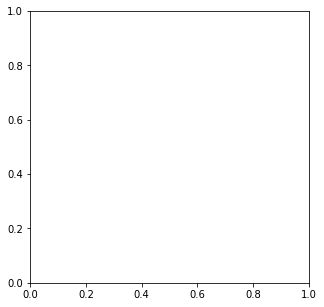

In [80]:
labels_array = ['IDC = 0', 'IDC = 1']
fig, ax = plt.subplots(1,figsize=(5,5))
ax = sns.heatmap(cnf_valid_matrix[mn][0], ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(labels_array)
ax.set_yticklabels(labels_array)
plt.title('Confusion matrix of validation set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

choose model

In [81]:
mn = 'DummyClassifier'

plot

NameError: name 'cnf_valid_matrix' is not defined

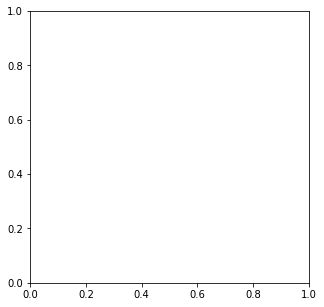

In [82]:
labels_array = ['IDC = 0', 'IDC = 1']
fig, ax = plt.subplots(1,figsize=(5,5))
ax = sns.heatmap(cnf_valid_matrix[mn][0], ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(labels_array)
ax.set_yticklabels(labels_array)
plt.title('Confusion matrix of validation set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();